<a href="https://colab.research.google.com/github/DennisR96/ASAI_08/blob/main/HoloGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HoloGAN:** Unsupervised Learning of 3D Representations From Natural Images

**Paper**

Implementation of *HoloGAN: Unsupervised learning of 3D representations from natural images* from Nguyen-Phuoc et al. (2019)

https://arxiv.org/pdf/1904.01326.pdf

**Github**

Based on the works of Edanur Demir and Gökhan Özsarı

https://github.com/eksuas/HoloGAN-PyTorch

## **Requirements**

### Installation

In [ ]:
!pip install gdown
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [ ]:
import argparse
import collections
import csv
import os
import imageio
import math
import numpy as np
import torch
import time

from torch import nn
from torch.autograd import Variable
from os import listdir
from os.path import isfile, join
from torch.optim import Adam
from torchvision import datasets, transforms
from datetime import datetime

## **Dataset**

In [ ]:
if os.path.exists("/content/img_align_celeba.zip" ):
    print("Dataset already downloaded.")
else:
    print("Downloading Dataset")
    !gdown 1j5UAKVh6CRsbOfRft7zI5KhF0dj6KtZQ
!mkdir celebA
!unzip -u "/content/img_align_celeba.zip" -d "/content/celebA/"

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
 extracting: /content/celebA/img_align_celeba/197600.jpg  
 extracting: /content/celebA/img_align_celeba/197601.jpg  
 extracting: /content/celebA/img_align_celeba/197602.jpg  
 extracting: /content/celebA/img_align_celeba/197603.jpg  
 extracting: /content/celebA/img_align_celeba/197604.jpg  
 extracting: /content/celebA/img_align_celeba/197605.jpg  
 extracting: /content/celebA/img_align_celeba/197606.jpg  
 extracting: /content/celebA/img_align_celeba/197607.jpg  
 extracting: /content/celebA/img_align_celeba/197608.jpg  
 extracting: /content/celebA/img_align_celeba/197609.jpg  
 extracting: /content/celebA/img_align_celeba/197610.jpg  
 extracting: /content/celebA/img_align_celeba/197611.jpg  
 extracting: /content/celebA/img_align_celeba/197612.jpg  
 extracting: /content/celebA/img_align_celeba/197613.jpg  
 extracting: /content/celebA/img_align_celeba/197614.jpg  
 extracting: /content/celebA/img_align_celeba/19

## **Model**

### Functions

**Adaptive Instance Normalization**

$\textrm{AdaIN}(x, y)= \sigma(y)\left(\frac{x-\mu(x)}{\sigma(x)}\right)+\mu(y)$

In [ ]:
def AdaIn(features, scale, bias):
    shape = features.shape
    new_shape = tuple(list(shape)[:2] + [1] * (len(shape)-2))
    moments = features.view(shape[0], shape[1], -1)
    mean = moments.mean(2).reshape(new_shape)
    variance = moments.var(2).reshape(new_shape)
    sigma = torch.rsqrt(variance + 1e-8)
    normalized = (features - mean) * sigma
    scale_broadcast = scale.reshape(mean.shape)
    bias_broadcast = bias.reshape(mean.shape)
    normalized = scale_broadcast * normalized
    normalized += bias_broadcast
    return normalized

**Truncated Normal Initializer**

In [ ]:
def truncated_normal_initializer(weight, mean=0, std=0.02):
    size = weight.shape
    tmp = weight.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    weight.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    weight.data.mul_(std).add_(mean)

### Generator
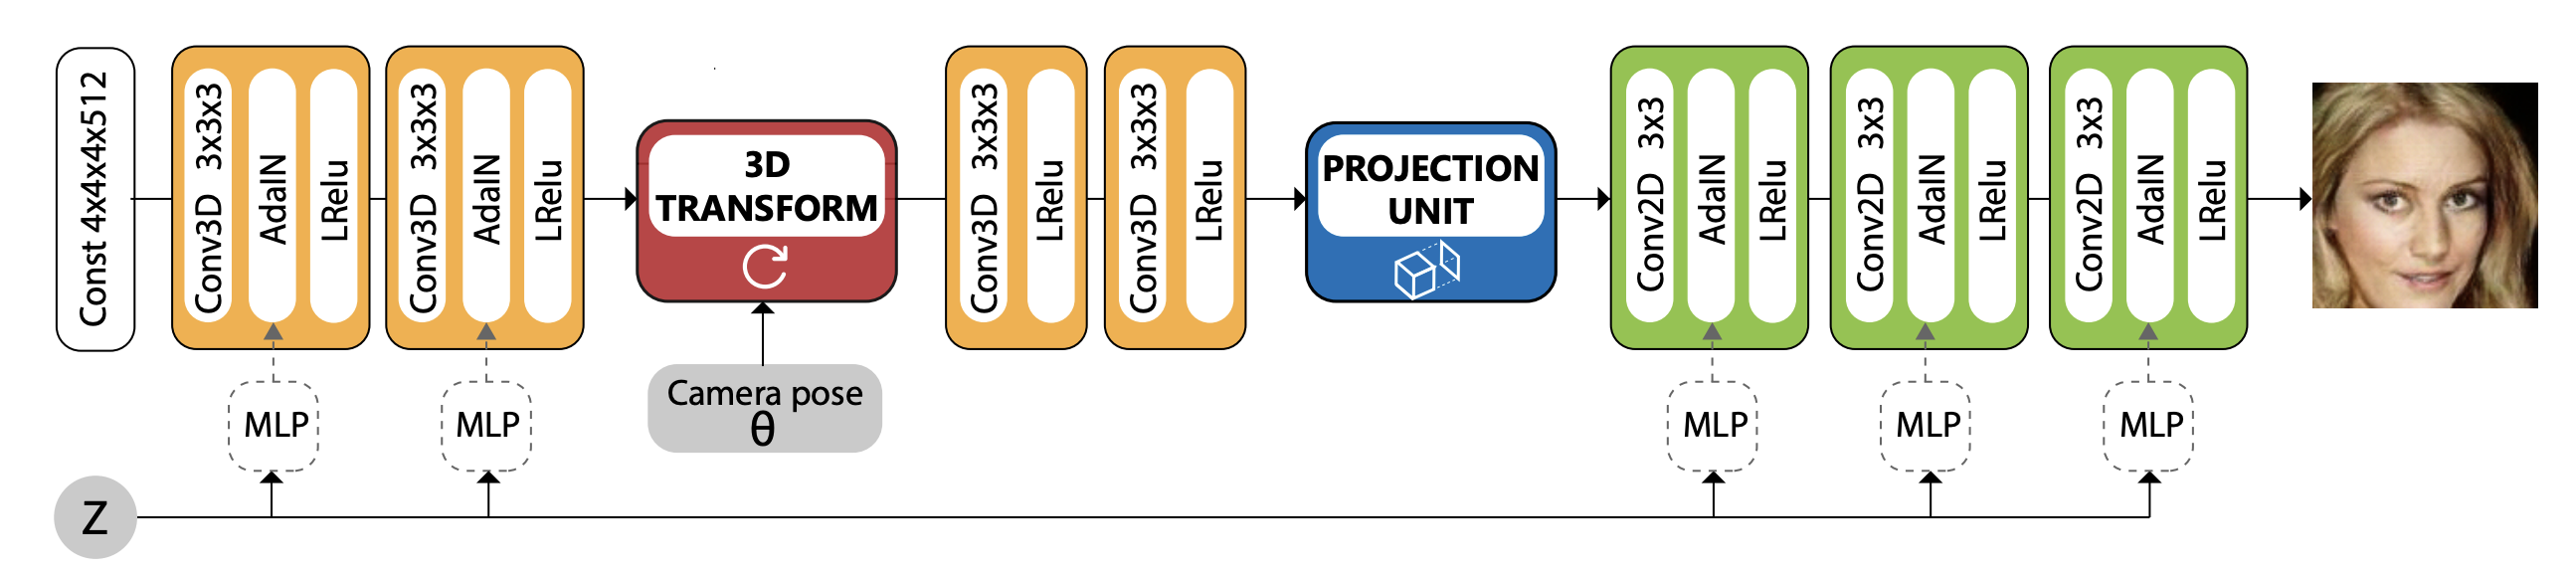

**Z - Noise Vector used as a style controller**
- $z_1$ - Objects and Shapes (3D)
- $z_2$ - Texture and Lightning (2D)

**White – Constant Layer**

- 4D Constant Layer

**Yellow – Conv3D**

- Conv3D - Learns 3D representation

**ZMapping**



*   Linear(in_features, out_features, bias)
*   ReLU()




In [ ]:
class ZMapping(nn.Module):
    def __init__(self, z_dimension, output_channel):
        super(ZMapping, self).__init__()
        self.output_channel = output_channel
        self.linear1 = nn.Linear(z_dimension, output_channel * 2)
        nn.init.normal_(self.linear1.weight, std=0.02)
        nn.init.constant_(self.linear1.bias, val=0.0)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.linear1(x))
        return out[:, :self.output_channel], out[:, self.output_channel:]

**Basic Block (Generator)**


*   ConvTranspose2D or ConvTranspose3D
*   ZMapping
*   AdaIN
*   ReLU





In [ ]:
class G_BasicBlock(nn.Module):
    """Basic Block defition of the Generator.
    """
    def __init__(self, z_planes, in_planes, out_planes, transpose_dim):
        super(G_BasicBlock, self).__init__()
        if transpose_dim == 2:
            self.convTranspose = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4,
                                                    stride=2, padding=1)
        else:
            self.convTranspose = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=3,
                                                    stride=2, output_padding=1, padding=1)

        nn.init.normal_(self.convTranspose.weight, std=0.02)
        nn.init.constant_(self.convTranspose.bias, val=0.0)
        self.zMapping = ZMapping(z_planes, out_planes)
        self.relu = nn.ReLU()

    def forward(self, h, z):
        h = self.convTranspose(h)
        s, b = self.zMapping(z)
        h = AdaIn(h, s, b)
        h = self.relu(h)
        return h

**Generator**

**Transformation3D**

*Scaling-Matrix*

$S_{v}={\begin{bmatrix}v_{x}&0&0&0\\0&v_{y}&0&0\\0&0&v_{z}&0\\0&0&0&1\end{bmatrix}}$

*Rotation azimuth - Clockwise*

$ 
R_{\text{azimuth}}(\theta) = 
\begin{bmatrix}
\cos(\theta) & \sin(\theta) & 0 & 0 \\
-\sin(\theta) & \cos(\theta) & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$

**Interpolation**
- Trilinear Interpolation
https://en.wikipedia.org/wiki/Trilinear_interpolation

**Meshgrid**

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_planes, out_planes, z_planes, view_planes=6, gpu=True):
        super(Generator, self).__init__()
        self.device = torch.device("cuda" if gpu else "cpu")
        tensor = (torch.randn(1, in_planes*8, 4, 4, 4) - 0.5 ) / 0.5
        self.x = nn.Parameter(tensor.to(self.device))
        self.x.requires_grad = True

        self.zMapping = ZMapping(z_planes, in_planes*8)
        self.block1 = G_BasicBlock(z_planes, in_planes=in_planes*8, out_planes=in_planes*2,
                                 transpose_dim=3)
        self.block2 = G_BasicBlock(z_planes, in_planes=in_planes*2, out_planes=in_planes,
                                 transpose_dim=3)

        self.convTranspose2d1 = nn.ConvTranspose2d(in_planes*16, in_planes*16, kernel_size=1)
        nn.init.normal_(self.convTranspose2d1.weight, std=0.02)
        nn.init.constant_(self.convTranspose2d1.bias, val=0.0)

        self.block3 = G_BasicBlock(z_planes, in_planes=in_planes*16, out_planes=in_planes*4,
                                 transpose_dim=2)
        self.block4 = G_BasicBlock(z_planes, in_planes=in_planes*4, out_planes=in_planes,
                                 transpose_dim=2)

        self.convTranspose2d2 = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, padding=1)
        nn.init.normal_(self.convTranspose2d2.weight, std=0.02)
        nn.init.constant_(self.convTranspose2d2.bias, val=0.0)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z, view_in):

        batch_size = z.shape[0]
        x = self.x.repeat(batch_size, 1, 1, 1, 1)
        s0, b0 = self.zMapping(z)
        h0 = AdaIn(x, s0, b0)
        h0 = self.relu(h0)

        # Yellow - 3D Convolution
        h1 = self.block1(h0, z)
        h2 = self.block2(h1, z)

        # Red - 3D Transformation
        h2_rotated = self.transformation3d(h2, view_in, 16, 16)
        h2_rotated = h2_rotated.permute(0, 1, 3, 2, 4)
        inv_idx = torch.arange(h2_rotated.size(2)-1, -1, -1).long()
        h2_rotated = h2_rotated[:, :, inv_idx, :, :]
        h2_2d = h2_rotated.reshape(batch_size, -1, 16, 16)

        # Green - 
        h3 = self.convTranspose2d1(h2_2d)
        h3 = self.relu(h3)

        h4 = self.block3(h3, z)
        h5 = self.block4(h4, z)

        h6 = self.convTranspose2d2(h5)
        h6 = self.tanh(h6)
        return h6

    def transformation3d(self, voxel_array, view_params, size=16, new_size=16):
        # TODO: daha efficient olması için ileri de tek bir matrix formatında oluşturulabilir

        theta = Variable(torch.as_tensor(view_params[:, 0].reshape(-1, 1, 1)).float(),
                         requires_grad=True).to(self.device)
        gamma = Variable(torch.as_tensor(view_params[:, 1].reshape(-1, 1, 1)).float(),
                         requires_grad=True).to(self.device)
        ones  = torch.ones(theta.shape, requires_grad=True).to(self.device)
        zeros = torch.zeros(theta.shape, requires_grad=True).to(self.device)

        # Rotation azimuth (i.e. rotate around-z)
        rot_z = torch.cat([
            torch.cat([theta.cos(),   theta.sin(),  zeros,  zeros], dim=2),
            torch.cat([-theta.sin(),  theta.cos(),  zeros,  zeros], dim=2),
            torch.cat([zeros,         zeros,        ones,   zeros], dim=2),
            torch.cat([zeros,         zeros,        zeros,  ones],  dim=2)], dim=1)

        # Rotation elevation (i.e. rotate around-x)
        rot_y = torch.cat([
            torch.cat([gamma.cos(),   zeros,  gamma.sin(),  zeros], dim=2),
            torch.cat([zeros,         ones,   zeros,        zeros], dim=2),
            torch.cat([-gamma.sin(),  zeros,  gamma.cos(),  zeros], dim=2),
            torch.cat([zeros,         zeros,  zeros,        ones],  dim=2)], dim=1)

        rotation_matrix = torch.matmul(rot_z, rot_y)

        # Scaling matrix
        scale = Variable(torch.as_tensor(view_params[:, 2].reshape(-1, 1, 1)).float(),
                         requires_grad=True).to(self.device)
        scaling_matrix = torch.cat([
            torch.cat([scale, zeros,  zeros, zeros], dim=2),
            torch.cat([zeros, scale,  zeros, zeros], dim=2),
            torch.cat([zeros, zeros,  scale, zeros], dim=2),
            torch.cat([zeros, zeros,  zeros, ones],  dim=2)], dim=1)

        # Translation matrix
        x_shift = Variable(torch.as_tensor(view_params[:,3].reshape(-1, 1, 1)).float(),
                           requires_grad=True).to(self.device)
        y_shift = Variable(torch.as_tensor(view_params[:,4].reshape(-1, 1, 1)).float(),
                           requires_grad=True).to(self.device)
        z_shift = Variable(torch.as_tensor(view_params[:,5].reshape(-1, 1, 1)).float(),
                           requires_grad=True).to(self.device)
        translation_matrix = torch.cat([
            torch.cat([ones,  zeros, zeros, x_shift], dim=2),
            torch.cat([zeros, ones,  zeros, y_shift], dim=2),
            torch.cat([zeros, zeros, ones,  z_shift], dim=2),
            torch.cat([zeros, zeros, zeros, ones],    dim=2)], dim=1)

        transformation_matrix = torch.matmul(translation_matrix, scaling_matrix)
        transformation_matrix = torch.matmul(transformation_matrix, rotation_matrix)

        return self.apply_transformation(voxel_array, transformation_matrix, size, new_size)

    def apply_transformation(self, voxel_array, transformation_matrix, size=16, new_size=16):

        batch_size = voxel_array.shape[0]
        # Aligning the centroid of the object (voxel grid) to origin for rotation,
        # then move the centroid back to the original position of the grid centroid
        centroid = Variable(torch.tensor([[1, 0, 0, -size * 0.5],
                                          [0, 1, 0, -size * 0.5],
                                          [0, 0, 1, -size * 0.5],
                                          [0, 0, 0,           1]]),
                                          requires_grad=True).to(self.device)
        centroid = centroid.reshape(1, 4, 4).repeat(batch_size, 1, 1)

        # However, since the rotated grid might be out of bound for the original grid size,
        # move the rotated grid to a new bigger grid
        centroid_new = Variable(torch.tensor([[1, 0, 0, new_size * 0.5],
                                              [0, 1, 0, new_size * 0.5],
                                              [0, 0, 1, new_size * 0.5],
                                              [0, 0, 0,              1]]),
                                              requires_grad=True).to(self.device)
        centroid_new = centroid_new.reshape(1, 4, 4).repeat(batch_size, 1, 1)

        transformed_centoid = torch.matmul(centroid_new, transformation_matrix)
        transformed_centoid = torch.matmul(transformed_centoid, centroid)
        transformed_centoid = transformed_centoid.inverse()
        #Ignore the homogenous coordinate so the results are 3D vectors
        #transformed_centoid = transformed_centoid[:, 0:3, :]

        grid = self.meshgrid(new_size, new_size, new_size)
        grid = grid.reshape(1, grid.shape[0], grid.shape[1])
        grid = grid.repeat(batch_size, 1, 1)

        grid_transform = torch.matmul(transformed_centoid, grid)
        x_flat = grid_transform[:, 0, :].reshape(-1)
        y_flat = grid_transform[:, 1, :].reshape(-1)
        z_flat = grid_transform[:, 2, :].reshape(-1)

        n_channels = voxel_array.shape[1]
        """
        out_shape = (batch_size, n_channels, new_size, new_size, new_size)
        transformed = self.interpolation(voxel_array, x_flat, y_flat, z_flat, new_size)
        transformed = transformed.reshape(out_shape)
        """
        transformed = self.interpolation(voxel_array, x_flat, y_flat, z_flat, new_size)
        out_shape = (batch_size, new_size, new_size, new_size, n_channels)
        transformed = transformed.reshape(out_shape).permute(0, 4, 1, 2, 3)
        return transformed

    def interpolation(self, voxel_array, x, y, z, size):
        batch_size, n_channels, height, width, depth = voxel_array.shape

        # do sampling
        x0 = torch.floor(x).long()
        x1 = x0 + 1
        y0 = torch.floor(y).long()
        y1 = y0 + 1
        z0 = torch.floor(z).long()
        z1 = z0 + 1

        x0 = torch.clamp(x0, 0, width-1)
        x1 = torch.clamp(x1, 0, width-1)
        y0 = torch.clamp(y0, 0, height-1)
        y1 = torch.clamp(y1, 0, height-1)
        z0 = torch.clamp(z0, 0, depth-1)
        z1 = torch.clamp(z1, 0, depth-1)

        rep  = torch.ones(1, size * size * size).long()
        base = torch.arange(batch_size) * width * height * depth
        base = torch.matmul(base.reshape(-1, 1), rep).reshape(-1).to(self.device)

        #Find the Z element of each index
        base_z0 = base + z0 * width * height
        base_z1 = base + z1 * width * height

        #Find the Y element based on Z
        base_z0_y0 = base_z0 + y0 * width
        base_z0_y1 = base_z0 + y1 * width
        base_z1_y0 = base_z1 + y0 * width
        base_z1_y1 = base_z1 + y1 * width

        # Find the X element based on Y, Z for Z=0
        idx_a = (base_z0_y0 + x0)
        idx_b = (base_z0_y1 + x0)
        idx_c = (base_z0_y0 + x1)
        idx_d = (base_z0_y1 + x1)

        # Find the X element based on Y,Z for Z =1
        idx_e = (base_z1_y0 + x0)
        idx_f = (base_z1_y1 + x0)
        idx_g = (base_z1_y0 + x1)
        idx_h = (base_z1_y1 + x1)

        # use indices to lookup pixels in the flat image and restore channels dim
        voxel_flat = voxel_array.permute(0, 2, 3, 4, 1).reshape(-1, n_channels)
        #voxel_flat = voxel_array.reshape(-1, n_channels)
        Ia = voxel_flat[idx_a]
        Ib = voxel_flat[idx_b]
        Ic = voxel_flat[idx_c]
        Id = voxel_flat[idx_d]
        Ie = voxel_flat[idx_e]
        If = voxel_flat[idx_f]
        Ig = voxel_flat[idx_g]
        Ih = voxel_flat[idx_h]

        x0_f = x0.float()
        x1_f = x1.float()
        y0_f = y0.float()
        y1_f = y1.float()
        z0_f = z0.float()
        z1_f = z1.float()

        #First slice XY along Z where z=0
        wa = ((x1_f - x) * (y1_f - y) * (z1_f - z)).unsqueeze(1)
        wb = ((x1_f - x) * (y - y0_f) * (z1_f - z)).unsqueeze(1)
        wc = ((x - x0_f) * (y1_f - y) * (z1_f - z)).unsqueeze(1)
        wd = ((x - x0_f) * (y - y0_f) * (z1_f - z)).unsqueeze(1)

        # First slice XY along Z where z=1
        we = ((x1_f - x) * (y1_f - y) * (z - z0_f)).unsqueeze(1)
        wf = ((x1_f - x) * (y - y0_f) * (z - z0_f)).unsqueeze(1)
        wg = ((x - x0_f) * (y1_f - y) * (z - z0_f)).unsqueeze(1)
        wh = ((x - x0_f) * (y - y0_f) * (z - z0_f)).unsqueeze(1)

        target = wa * Ia + wb * Ib + wc * Ic + wd * Id + we * Ie + wf * If + wg * Ig + wh * Ih
        return target

    def meshgrid(self, height, width, depth):
        z, y, x = torch.meshgrid(torch.arange(depth).to(self.device),
                                 torch.arange(height).to(self.device),
                                 torch.arange(width).to(self.device))
        x_flat = x.reshape(1, -1).float()
        y_flat = y.reshape(1, -1).float()
        z_flat = z.reshape(1, -1).float()
        ones = torch.ones(x_flat.shape).float().to(self.device)
        return torch.cat([x_flat, y_flat, z_flat, ones], dim=0)

### Discriminator

**Basic Block**
1. Conv2D (In_Planes, Out_Planes, Kernel=5, Stride=2, Padding=2)
2. Spectral Normalization
3. Instance Normalization
4. LeakyRelu

In [ ]:
class D_BasicBlock(nn.Module):
    """Basic Block defition of the Discriminator.
    """
    def __init__(self, in_planes, out_planes):
        super(D_BasicBlock, self).__init__()
        self.conv2d = nn.Conv2d(in_planes, out_planes, kernel_size=5, stride=2, padding=2)
        truncated_normal_initializer(self.conv2d.weight)
        nn.init.constant_(self.conv2d.bias, val=0.0)
        self.conv2d_spec_norm = nn.utils.spectral_norm(self.conv2d)
        self.instance_norm = nn.InstanceNorm2d(out_planes)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.conv2d_spec_norm(x)
        out = self.instance_norm(out)
        out = self.lrelu(out)
        return out

**Discriminator**
- Conv2D
- Leaky Relu
- 3x Basic Block
- 4x Linear
- Sigmoid
- TanH

In [ ]:
class Discriminator(nn.Module):
    """Discriminator of HoloGAN
    """
    def __init__(self, in_planes, out_planes, z_planes):
        super(Discriminator, self).__init__()
        self.conv2d = nn.Conv2d(in_planes, out_planes, kernel_size=5, stride=2, padding=2)
        truncated_normal_initializer(self.conv2d.weight)
        nn.init.constant_(self.conv2d.bias, val=0.0)

        self.lrelu = nn.LeakyReLU(0.2)
        self.blocks = nn.Sequential(
            D_BasicBlock(out_planes*1, out_planes*2),
            D_BasicBlock(out_planes*2, out_planes*4),
            D_BasicBlock(out_planes*4, out_planes*8)
        )

        self.linear1 = nn.Linear(out_planes*8 * 4 * 4, 1)
        truncated_normal_initializer(self.linear1.weight)
        nn.init.constant_(self.linear1.bias, val=0.0)

        self.linear2 = nn.Linear(out_planes*8 * 4 * 4, 128)
        truncated_normal_initializer(self.linear1.weight)
        nn.init.constant_(self.linear2.bias, val=0.0)

        self.linear3 = nn.Linear(128, z_planes)
        truncated_normal_initializer(self.linear1.weight)
        nn.init.constant_(self.linear3.bias, val=0.0)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        batch_size = x.size(0)
        x0 = self.lrelu(self.conv2d(x))
        x3 = self.blocks(x0)
        # Flatten
        x3 = x3.view(batch_size, -1)

        # Returning logits to determine whether the images are real or fake
        x4 = self.linear1(x3)

        # Recognition network for latent variables has an additional layer
        encoder = self.lrelu(self.linear2(x3))
        z_prediction = self.tanh(self.linear3(encoder))

        return x4, z_prediction

### HoloGAN

In [ ]:
class HoloGAN():
    """HoloGAN.

    HoloGAN model is the Unsupervised learning of 3D representations from natural images.
    The paper can be found in https://www.monkeyoverflow.com/hologan-unsupervised-learning-\
    of-3d-representations-from-natural-images/
    """
    def __init__(self, args):
        super(HoloGAN, self).__init__()

        torch.manual_seed(args.seed)
        use_cuda = args.gpu and torch.cuda.is_available()
        args.device = torch.device("cuda" if use_cuda else "cpu")

        # model configurations
        if args.load_dis is None:
            self.discriminator = Discriminator(in_planes=3, out_planes=64,
                                               z_planes=args.z_dim).to(args.device)
        else:
            self.discriminator = torch.load(args.load_dis).to(args.device)

        if args.load_gen is None:
            self.generator = Generator(in_planes=64, out_planes=3,
                                       z_planes=args.z_dim, gpu=use_cuda).to(args.device)
        else:
            self.generator = torch.load(args.load_gen).to(args.device)

        # optimizer configurations
        self.optimizer_discriminator = Adam(self.discriminator.parameters(),
                                            lr=args.d_lr, betas=(args.beta1, args.beta2))
        self.optimizer_generator = Adam(self.generator.parameters(),
                                        lr=args.d_lr, betas=(args.beta1, args.beta2))

        # Load dataset
        self.train_loader = self.load_dataset(args)

        # create result folder
        args.results_dir = os.path.join("results", args.dataset)
        if not os.path.exists(args.results_dir):
            os.makedirs(args.results_dir)

        # create history file
        args.hist_file = open(os.path.join(args.results_dir, "history.csv"), "a", newline="")
        args.recorder = csv.writer(args.hist_file, delimiter=",")
        if os.stat(os.path.join(args.results_dir, "history.csv")).st_size == 0:
            args.recorder.writerow(["epoch", "time", "d_loss", "g_loss", "q_loss"])

        # create model folder
        args.models_dir = os.path.join("models", args.dataset)
        if not os.path.exists(args.models_dir):
            os.makedirs(args.models_dir)

        # continue to broken training
        args.start_epoch = 0
        if args.load_dis is None:
            load_model = ""
            for modelname in listdir(args.models_dir):
                if isfile(join(args.models_dir, modelname)) and \
                   ("discriminator.v" in modelname or "generator.v" in modelname):
                    start_loc = modelname[:-3].rfind(".v") + 2
                    end_loc = modelname[:-3].rfind("_")
                    epoch_str = modelname[start_loc:end_loc]
                    batch_str = modelname[end_loc:]
                    dis_model = os.path.join(args.models_dir, "discriminator.v"+epoch_str+batch_str)
                    gen_model = os.path.join(args.models_dir, "generator.v"+epoch_str+batch_str)
                    if args.start_epoch < int(epoch_str) and os.path.exists(dis_model) and os.path.exists(gen_model):
                        args.start_epoch = int(epoch_str)
                        load_model = epoch_str + batch_str

            if args.start_epoch > 0:
                print("Broken training is detected. Starting epoch is", args.start_epoch)
                dis_model = os.path.join(args.models_dir, "discriminator.v"+load_model)
                gen_model = os.path.join(args.models_dir, "generator.v"+load_model)
                self.discriminator = torch.load(dis_model).to(args.device)
                self.generator = torch.load(gen_model).to(args.device)

        # create sampling folder
        args.samples_dir = os.path.join("samples", args.dataset)
        if not os.path.exists(args.samples_dir):
            os.makedirs(args.samples_dir)

    def train(self, args):
        """HoloGAN trainer

        This method train the HoloGAN model.
        """
        d_lr = args.d_lr
        g_lr = args.g_lr
        for epoch in range(args.start_epoch, args.max_epochs):
            # Adaptive learning rate
            if epoch >= args.epoch_step:
                adaptive_lr = (args.max_epochs - epoch) / (args.max_epochs - args.epoch_step)
                d_lr *= adaptive_lr
                g_lr *= adaptive_lr
                for param_group in self.optimizer_discriminator.param_groups:
                    param_group['lr'] = d_lr
                for param_group in self.optimizer_generator.param_groups:
                    param_group['lr'] = g_lr

            result = collections.OrderedDict({"epoch":epoch})
            result.update(self.train_epoch(args, epoch))
            # validate and keep history at each log interval
            self.save_history(args, result)

        # save the model giving the best validation results as a final model
        if not args.no_save_model:
            self.save_model(args, args.max_epochs-1, best=True)

    def train_epoch(self, args, epoch):
        """train an epoch

        This method train an epoch.
        """
        batch = {"time":[], "g":[], "d":[], "q":[]}
        self.generator.train()
        self.discriminator.train()
        original_batch_size = args.batch_size
        for idx, (data, _) in enumerate(self.train_loader):
            print("Epoch: [{:2d}] [{:3d}/{:3d}] ".format(epoch, idx, len(self.train_loader)), end="")
            x = data.to(args.device)
            args.batch_size = len(x)
            # rnd_state = np.random.RandomState(seed)
            z = self.sample_z(args)
            view_in = self.sample_view(args)

            d_loss, g_loss, q_loss, elapsed_time = self.train_batch(x, z, view_in, args, idx)
            batch["d"].append(float(d_loss))
            batch["g"].append(float(g_loss))
            batch["q"].append(float(q_loss))
            batch["time"].append(float(elapsed_time))

            # print the training results of batch
            print("time: {:.2f}sec, d_loss: {:.4f}, g_loss: {:.4f}, q_loss: {:.4f}"
                  .format(elapsed_time, float(d_loss), float(g_loss), float(q_loss)))

            if (idx % args.log_interval == 0):
                self.sample(args, epoch, idx, collection=True)
                # save model parameters
                if not args.no_save_model:
                    self.save_model(args, epoch, idx)

        result = {"time"  : round(np.mean(batch["time"])),
                  "d_loss": round(np.mean(batch["d"]), 4),
                  "g_loss": round(np.mean(batch["g"]), 4),
                  "q_loss": round(np.mean(batch["q"]), 4)}
        args.batch_size = original_batch_size
        return result

    def train_batch(self, x, z, view_in, args, batch_id):
        """train the given batch

        Arguments are
        * x:        images in the batch.
        * z:        latent variables in the batch.
        * view_in:  3D transformation parameters.

        This method train the given batch and return the resulting loss values.
        """
        start = time.process_time()
        loss = nn.BCEWithLogitsLoss()

        # Train the generator.
        self.optimizer_generator.zero_grad()
        fake = self.generator(z, view_in)
        d_fake, g_z_pred = self.discriminator(fake[:, :, :64, :64])
        one = torch.ones(d_fake.shape).to(args.device)
        gen_loss = loss(d_fake, one)
        q_loss = torch.mean((g_z_pred - z)**2)
        if batch_id % args.update_g_every_d == 0:
            (gen_loss + args.lambda_latent * q_loss).backward()
            self.optimizer_generator.step()

        # Train the discriminator.
        self.optimizer_discriminator.zero_grad()
        d_fake, d_z_pred = self.discriminator(fake[:, :, :64, :64].detach())
        d_real, _ = self.discriminator(x)
        one = torch.ones(d_real.shape).to(args.device)
        zero = torch.zeros(d_fake.shape).to(args.device)
        dis_loss = loss(d_real, one) + loss(d_fake, zero)
        q_loss = torch.mean((d_z_pred - z)**2)
        (dis_loss + args.lambda_latent * q_loss).backward()
        self.optimizer_discriminator.step()

        elapsed_time = time.process_time()  - start
        return float(dis_loss), float(gen_loss), float(q_loss), elapsed_time

    def sample(self, args, epoch=0, batch=0, trained=False, collection=False):
        """HoloGAN sampler

        This samples images in the given configuration from the HoloGAN.
        Images can be found in the "args.samples_dir" directory.
        """
        z = self.sample_z(args)
        if args.rotate_azimuth:
            low, high, step = args.azimuth_low, args.azimuth_high+1, 5
        elif args.rotate_elevation:
            low, high, step = args.elevation_low, args.elevation_high, 5
        else:
            low, high, step = 0, 10, 1

        if not trained:
            folder = os.path.join(args.samples_dir, "epoch"+str(epoch)+"_"+str(batch))
        else:
            now = datetime.now()
            timestamp = datetime.timestamp(now)
            folder = os.path.join(args.samples_dir, "sample_"+str(timestamp))

        if not os.path.exists(folder):
            os.makedirs(folder)

        for i in range(low, high, step):
            # Apply only azimuth rotation
            if args.rotate_azimuth:
                view_in = torch.tensor([i*math.pi/180, 0, 1.0, 0, 0, 0])
                view_in = view_in.repeat(args.batch_size, 1)
            # Apply only elevation rotation
            elif args.rotate_elevation:
                view_in = torch.tensor([270*math.pi/180, i*math.pi/180, 1.0, 0, 0, 0])
                view_in = view_in.repeat(args.batch_size, 1)
            # Apply default transformation
            else:
                view_in = self.sample_view(args)

            samples = self.generator(z, view_in).permute(0, 2, 3, 1)
            normalized = ((samples+1.)/2.).cpu().detach().numpy()
            image = np.clip(255*normalized, 0, 255).astype(np.uint8)

            if collection and args.batch_size >= 4:
                merged_image = self.merge_samples(image, [args.batch_size // 4, 4])
                merged_image = np.array(merged_image, dtype=np.uint8)
                imageio.imwrite(os.path.join(folder, "samples_" + str(i) + ".png"), merged_image)
            else:
                image_0 = np.array(image[0], dtype=np.uint8)
                imageio.imwrite(os.path.join(folder, "samples_" + str(i) + ".png"), image_0)


            '''
            if collection and args.batch_size >= 4:
                imageio.imsave(os.path.join(folder, "samples_"+str(i)+".png"),
                       self.merge_samples(image, [args.batch_size // 4, 4]))
            else:
                imageio.imsave(os.path.join(folder, "samples_"+str(i)+".png"), image[0])
            '''
            

            if trained:
                print("Samples are saved in", os.path.join(folder, "samples_"+str(i)+".png"))

    def load_dataset(self, args):
        """dataset loader.

        This loads the dataset.
        """
        kwargs = {'num_workers': 2, 'pin_memory': True} if args.device == 'cuda' else {}

        if args.dataset == 'celebA':
            transform = transforms.Compose([\
                transforms.CenterCrop(108),
                transforms.Resize(64),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

            trainset = datasets.ImageFolder(root=args.image_path, transform=transform)

        train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,\
                        shuffle=True, **kwargs)
        return train_loader

    def sample_z(self, args):
        """Latent variables sampler

        This samples latent variables from the uniform distribution [-1,1].
        """
        tensor = torch.cuda.FloatTensor if args.device == "cuda" else torch.FloatTensor
        size = (args.batch_size, args.z_dim)
        return tensor(np.random.uniform(-1., 1., size)).to(args.device)

    def sample_view(self, args):
        """Transformation parameters sampler

        This samples view (or transformation parameters) from the given configuration.
        """
        # the azimuth angle (theta) is around y
        theta = np.random.randint(args.azimuth_low, args.azimuth_high,
                                  (args.batch_size)).astype(np.float)
        theta = theta * math.pi / 180.0

        # the elevation angle (gamma) is around x
        if args.elevation_low < args.elevation_high:
            gamma = np.random.randint(args.elevation_low, args.elevation_high,
                                      (args.batch_size)).astype(np.float)
            gamma = gamma * math.pi / 180.0
        else:
            gamma = np.zeros(args.batch_size).astype(np.float)

        scale = float(np.random.uniform(args.scale_low, args.scale_high))
        shift_x = args.transX_low + np.random.random(args.batch_size) * \
                  (args.transX_high - args.transX_low)
        shift_y = args.transY_low + np.random.random(args.batch_size) * \
                  (args.transY_high - args.transY_low)
        shift_z = args.transZ_low + np.random.random(args.batch_size) * \
                  (args.transZ_high - args.transZ_low)

        view = np.zeros((args.batch_size, 6))
        column = np.arange(0, args.batch_size)
        view[column, 0] = theta
        view[column, 1] = gamma
        view[column, 2] = scale
        view[column, 3] = shift_x
        view[column, 4] = shift_y
        view[column, 5] = shift_z
        return view

    def save_history(self, args, record):
        """save a record to the history file"""
        args.recorder.writerow([str(record[key]) for key in record])
        args.hist_file.flush()

    def save_model(self, args, epoch, batch=0, best=False):
        """save model

        Arguments are
        * epoch:   epoch number.
        * best:    if the model is in the final epoch.

        This method saves the trained discriminator and generator in a pt file.
        """
        if best is False:
            dis_model = os.path.join(args.models_dir, "discriminator.v"+str(epoch)+"_"+str(batch)+".pt")
            gen_model = os.path.join(args.models_dir, "generator.v"+str(epoch)+"_"+str(batch)+".pt")
            torch.save(self.discriminator, dis_model)
            torch.save(self.generator, gen_model)
        else:
            batch = len(self.train_loader)-1
            dis_model = os.path.join(args.models_dir, "discriminator.v"+str(epoch)+"_"+str(batch)+".pt")
            gen_model = os.path.join(args.models_dir, "generator.v"+str(epoch)+"_"+str(batch)+".pt")
            while batch > 0 and not (os.path.exists(dis_model) and os.path.exists(gen_model)):
                batch -= 1
                dis_model = os.path.join(args.models_dir, "discriminator.v"+str(epoch)+"_"+str(batch)+".pt")
                gen_model = os.path.join(args.models_dir, "generator.v"+str(epoch)+"_"+str(batch)+".pt")

            train_files = os.listdir(args.models_dir)
            for train_file in train_files:
                if not train_file.endswith(".v"+str(epoch)+"_"+str(batch)+".pt"):
                    os.remove(os.path.join(args.models_dir, train_file))

            os.rename(dis_model, os.path.join(args.models_dir, "discriminator.pt"))
            os.rename(gen_model, os.path.join(args.models_dir, "generator.pt"))

    def merge_samples(self, images, size):
        _, h, w, c = images.shape
        collection = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            collection[j*h : j*h+h, i*w : i*w+w, :] = image
        return collection

## **Start**

### Initialize Model

In [ ]:
from easydict import EasyDict

def initializer():
    """Initializer of the program.

    This parses and extracts all training and testing settings.
    """
    #pylint: disable=C0326, C0330
    parser = EasyDict()
    #@markdown ## **HoloGAN**
    #@markdown ### Model
    parser.dataset = "celebA" #@param {type:"string"}
    parser.gpu = False #@param {type:"boolean"}
    parser.image_path = "/content/celebA/" #@param {type:"string"}
    parser.load_dis = None #@param {type:"string"}
    parser.load_gen = None #@param {type:"string"}
    parser.seed = 23
    #@markdown ### Parameter
    parser.batch_size = 32 #@param {type:"number"}
    parser.beta1 = 0.5 #@param {type:"number"}
    parser.beta2 = 0.999 #@param {type:"number"}
    parser.d_lr = 0.0001 #@param {type:"number"}
    parser.g_lr = 0.0001 #@param {type:"number"}
    parser.epoch_step = 25 #@param {type:"number"}
    parser.lambda_latent = 0.0 #@param {type:"number"}
    parser.log_interval = 1000 #@param {type:"number"}
    parser.max_epochs = 50 #@param {type:"number"}
    parser.z_dim = 128 #@param {type:"number"}


    #@markdown ### Images
    parser.azimuth_high = 65 #@param {type:"number"}
    parser.azimuth_low = 25 #@param {type:"number"}
    parser.rotate_azimuth = False #@param {type:"boolean"}
    parser.elevation_high = 0 #@param {type:"number"}
    parser.elevation_low = 0 #@param {type:"number"}
    parser.rotate_elevation = False #@param {type:"boolean"}
    parser.scale_high = 1.0 #@param {type:"number"}
    parser.scale_low = 1.0 #@param {type:"number"}

    parser.no_save_model = False #@param {type:"boolean"}
    parser.parser.sampling = False #@param {type:"boolean"}
 

    parser.sampling = False #@param {type:"boolean"}
    parser.transX_high = 0 #@param {type:"number"}
    parser.transX_low = 0 #@param {type:"number"}
    parser.transY_high = 0 #@param {type:"number"}
    parser.transY_low = 0 #@param {type:"number"}
    parser.transZ_high = 0 #@param {type:"number"}
    parser.transZ_low = 0 #@param {type:"number"}
    parser.update_g_every_d = 5 #@param {type:"number"}
    return parser

args = initializer()
torch.cuda.manual_seed_all(args.seed)


In [ ]:

model = HoloGAN(args)
if not args.sampling:
    model.train(args)
model.sample(args, trained=True, collection=True)

Epoch: [ 0] [  0/6332] 

<ipython-input-11-057d6bc88467>:285: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (args.batch_size)).astype(np.float)
<ipython-input-11-057d6bc88467>:294: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gamma = np.zeros(args.batch_size).astype(np.float)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch: [ 2] [2654/6332] time: 0.06sec, d_loss: 0.1025, g_loss: 4.7263, q_loss: 0.3634
Epoch: [ 2] [2655/6332] time: 0.18sec, d_loss: 0.1060, g_loss: 6.7992, q_loss: 0.3614
Epoch: [ 2] [2656/6332] time: 0.06sec, d_loss: 0.0862, g_loss: 7.6191, q_loss: 0.3617
Epoch: [ 2] [2657/6332] time: 0.06sec, d_loss: 0.0707, g_loss: 6.7580, q_loss: 0.3678
Epoch: [ 2] [2658/6332] time: 0.06sec, d_loss: 0.0440, g_loss: 6.5028, q_loss: 0.3626
Epoch: [ 2] [2659/6332] time: 0.06sec, d_loss: 0.0275, g_loss: 6.0070, q_loss: 0.3623
Epoch: [ 2] [2660/6332] time: 0.18sec, d_loss: 0.0136, g_loss: 7.1654, q_loss: 0.3614
Epoch: [ 2] [2661/6332] time: 0.06sec, d_loss: 0.0708, g_loss: 5.0038, q_loss: 0.3577
Epoch: [ 2] [2662/6332] time: 0.06sec, d_loss: 0.0443, g_loss: 6.3950, q_loss: 0.3560
Epoch: [ 2] [2663/6332] time: 0.06sec, d_loss: 0.0945, g_loss: 8.6349, q_loss: 0.3733
Epoch: [ 2] [2664/6332] time: 0.06sec, d_loss: 0.0508, g_loss: 7.3639, q_

KeyboardInterrupt: ignored

In [ ]:
x = model.sample(args, trained=True, collection=True)

<ipython-input-11-057d6bc88467>:285: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (args.batch_size)).astype(np.float)
<ipython-input-11-057d6bc88467>:294: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gamma = np.zeros(args.batch_size).astype(np.float)


Samples are saved in samples/celebA/sample_1685293869.316908/samples_0.png
Samples are saved in samples/celebA/sample_1685293869.316908/samples_1.png
Samples are saved in samples/celebA/sample_1685293869.316908/samples_2.png
Samples are saved in samples/celebA/sample_1685293869.316908/samples_3.png
Samples are saved in samples/celebA/sample_1685293869.316908/samples_4.png
Samples are saved in samples/celebA/sample_1685293869.316908/samples_5.png
Samples are saved in samples/celebA/sample_1685293869.316908/samples_6.png
Samples are saved in samples/celebA/sample_1685293869.316908/samples_7.png
Samples are saved in samples/celebA/sample_1685293869.316908/samples_8.png
Samples are saved in samples/celebA/sample_1685293869.316908/samples_9.png


In [ ]:
model.

None


**Create a GIF**

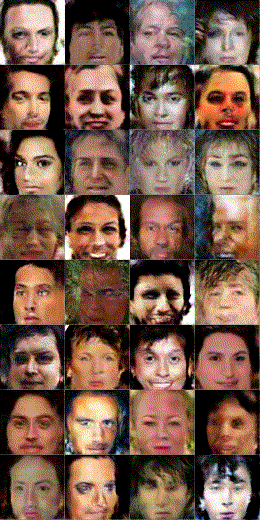

In [ ]:
from PIL import Image
import glob
from IPython.display import Image as IPImage
from IPython.display import display

# Function to create a GIF from a list of image paths
def create_gif(image_paths, gif_path, duration=200):
    images = []
    for path in image_paths:
        try:
            with Image.open(path) as img:
                images.append(img.copy())
        except IOError:
            print(f"Unable to open image file: {path}")
    
    # Save the images as frames of the GIF
    if images:
        images[0].save(
            gif_path,
            save_all=True,
            append_images=images[1:],
            duration=duration,
            loop=0
        )
        
        # Display the GIF
        display(IPImage(filename=gif_path))
    else:
        print("No valid images found.")

# Example usage
image_paths = glob.glob("/content/samples/celebA/epoch3_0/*.png")  # Replace with your image file paths
gif_path = "/content/samples/output.gif"  # Replace with the desired output path
create_gif(image_paths, gif_path)